# Part-01B: Preparing Amazon Reviews Home & Kitchen Subset

## Introduction

In this notebook, we focus on preparing a subset of Amazon reviews for the Home and Kitchen category. This involves several data preprocessing steps to ensure that the data is clean, relevant, and ready for detailed analysis. The main goals of this notebook are to filter and clean the data, combine reviews with metadata, and save the final subsets for further analysis.

#### Objectives

1. **Load and Combine Data**:
   - Efficiently load the raw review files and metadata for the Home and Kitchen category.
   - Combine the review and metadata files to create a unified dataset for analysis.

2. **Data Preprocessing**:
   - Filter the metadata to retain only relevant products.
   - Apply one-hot encoding to the categorical data.
   - Remove non-essential features to streamline the dataset.

3. **Create Meaningful Subsets**:
   - Identify products with sufficient review data for detailed analysis.
   - Group reviews by product, category, and other relevant features to focus the analysis on key items.

4. **Save the Final Subsets**:
   - Save the cleaned and filtered subsets of reviews and metadata for use in subsequent analysis steps.

By the end of this notebook, we will have a well-structured subset of Amazon reviews for the Home and Kitchen category, ready for in-depth analysis to extract valuable insights into customer preferences and sentiments.


In [73]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

# Load the Data

We will download our corpus of reviews and associated metadata for filtering.

In [74]:
## Import necessary packages
import pandas as pd
import nltk
import os, glob, json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth', 200)

In [75]:
import json, glob
with open('config/filepaths.json') as f:
    FPATHS = json.load(f)
FPATHS['data']['cleaned']

{'reviews-by-years_dict': {'dir': 'data/reviews-by-year/',
  'glob': 'data/reviews-by-year/*.*'},
 'metadata_csv-gz': 'data/metadata/amazon-metadata-groceries-combined.csv.gz',
 'asin-id-title-dict_json': 'data/metadata/amazon-groceries-asin-titles-lookup.json'}

In [76]:
q = FPATHS['data']['cleaned']['reviews-by-years_dict']['glob']
review_files = sorted(glob.glob(q))
len(review_files)

17

In [77]:
# folder_in = "reviews-by-year/"
# # sorted(os.listdir("split/"))
# review_files = sorted(glob.glob(folder_in+"*.*csv*"))
# len(review_files)

In [78]:

## Load metadata for filtering/selecting
# fpath_meta = 'metadata/amazon-metadata-groceries-gourmet-combined.csv.gz'
fpath_meta = FPATHS['data']['cleaned']['metadata_csv-gz']
df_meta = pd.read_csv(fpath_meta)
df_meta.head(10)

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,category.1,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[""['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']""]"
1,B008QMX2SG,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[""['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']""]"
2,B00D3M2QP4,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...","['Grocery &

In [79]:
df_meta.columns

Index(['asin', 'category', 'description', 'title', 'brand', 'feature', 'rank',
       'main_cat', 'price', 'imageURL', 'imageURLHighRes', 'details',
       'category.1', 'Category_Beverages',
       'Category_Bottled Beverages, Water & Drink Mixes',
       'Category_Candy & Chocolate',
       'Category_Canned, Jarred & Packaged Foods', 'Category_Coffee',
       'Category_Coffee, Tea & Cocoa', 'Category_Cooking & Baking',
       'Category_Grocery & Gourmet Food',
       'Category_Herbs, Spices & Seasonings',
       'Category_Sauces, Gravies & Marinades', 'Category_Snack Foods',
       'Category_Tea', 'category_list'],
      dtype='object')

In [80]:
# Drop unwanted cols
drop_cols_meta = ['also_buy','also_view','category_list'] #'category'
df_meta = df_meta.drop(columns=drop_cols_meta, errors='ignore')
df_meta

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,category.1,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea
0,B00BUKL666,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0
1,B008QMX2SG,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0
2,B00D3M2QP4,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...","['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']",0,0,0,0,0,0,0,1,0,0,0,0
3,B00542YXFW,"['Grocery & Gourmet Food', 'Beverages', 'Co

### Cleaning Metadata

#### Category List 

In [81]:
# Confirm string not list
df_meta.loc[0,'category']

"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"

In [82]:
import ast
# Use ast.literal_eval to convert strings to actual lists
df_meta['category_list'] = df_meta['category'].str.split("; ")#map(ast.literal_eval)
df_meta.loc[0,'category_list']

["['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"]

In [83]:
df_meta['category'] = df_meta['category_list'].map(lambda x: "; ".join(x))
df_meta.head()

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,category.1,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']]"
1,B008QMX2SG,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']]"
2,B00D3M2QP4,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...","['Grocery & Gourmet

In [84]:
category_list = df_meta['category_list'].explode().unique()#.sum()
category_list[:10]

array(["['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",
       "['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']",
       "['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Matcha']",
       "['Grocery & Gourmet Food', 'Cooking & Baking', 'Cooking Oils, Vinegars & Sprays', 'Oils', 'Coconut']",
       "['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Black']",
       "['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Coffee', 'Roasted Coffee Beans']",
       "['Grocery & Gourmet Food', 'Beverages', 'Bottled Beverages, Water & Drink Mixes', 'Energy Drinks']",
       "['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']",
       "['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Coffee', 'Single-Serve Capsules & Pods']",
       "['Grocery & Gourmet Food', 'Beverages', 'Bottled Beverages, Water & Drink Mixes', 'Flavor Syrups']"],
      dtype=obj

In [85]:
# all_categories = df_meta['category_list'].explode().unique().sum()
# all_categories[:10]

In [86]:
# Saving list of OHE category columns
cat_cols = [c for c in df_meta.columns if c.lower().startswith('category_')]
cat_cols[:10]

['Category_Beverages',
 'Category_Bottled Beverages, Water & Drink Mixes',
 'Category_Candy & Chocolate',
 'Category_Canned, Jarred & Packaged Foods',
 'Category_Coffee',
 'Category_Coffee, Tea & Cocoa',
 'Category_Cooking & Baking',
 'Category_Grocery & Gourmet Food',
 'Category_Herbs, Spices & Seasonings',
 'Category_Sauces, Gravies & Marinades']

## Selecting a Subset

- Need thoughtful consideration of selecting a product with a divisive overall reviews distribution

In [87]:
df_meta['brand'].value_counts()

brand
KIND                              9
Green Mountain Coffee Roasters    9
Crazy Cups                        8
Viva Naturals                     7
Starbucks                         7
                                 ..
Pantai Norasingh                  1
popchips                          1
Tealyra                           1
Epic Dental                       1
HealthWise                        1
Name: count, Length: 332, dtype: int64

## Loading and Merging Reviews & MetaData

#### Load & Combine Reviews-by-Year Files

In [88]:
## Load full corpus
df_full = pd.concat([pd.read_csv(f) for f in review_files]).reset_index(drop=True)
df_full.head(10)

,asin,reviewerID,reviewText,summary,overall,year
0,B00005IX97,A1TIVD0Y3KJSCN,"Using the Briel Chamonix machine I purchased from Amazon, I have produced delicious lattes using these pods. The smell of the Espressione pods (regular and decaf) when opened is incredible - dark,...",Better than Starbucks espresso pods,5.0,2002
1,B00006IDJZ,AZU2JDR2GVICQ,"Perhaps they've confused products and descriptions, but this is NOT soy.",This is NOT soy!,1.0,2002
2,B0000CH39R,A23GFTVIETX7DS,"See's Candies is a well-known California chocolate company, now with stores and distribution throughout the United States. In California, the lines to buy chocolate can snake out the door. I've ...",Excellent but not outstanding chocolates,4.0,2003
3,B0000DCXC8,ALB7HM3BWEUWF,"I plunked down my $80 for a bottle of the Pedroni ""Affinato"" (""Affinity"") balsamic vinegar and was sadly disappointed. To begin with, it comes with a catalog from A. G. Ferrari Foods which tells ...",Not As Advertised,3.0,2003
4,B0000TA1TG,A1KQ4K8AXXTWNK,The Blue Eyes herbal mix has an unexpectedly strong but delightful flavor; the Darjeeling is acceptable if undistinguished; The Yerba Mate and the African Red Bush are only for the brave (sort of ...,Gourmet tea sampler,3.0,2003
5,B00011TS3I,AMZVOS4H9AYR1,"I grew up in Kansas and a few times in my life I was fortunate enough to have home made, Kansas-grown wild plum jelly. When my package from The Red Buffalo arrived I tore it open to sample the wil...",Tastes like homemade,5.0,2003
6,B0000DBN1H,A281NPSIMI1C2R,"""There are few hours in life more agreeable than the hour dedicated to the ceremony known as afternoon tea."" -Henry James, Portrait of a Lady\n\nThis ""English Breakfast"" style tea is quite satisfy...",English Breakfast Style - High Quality Tea,5.0,2004
7,B0000DC2V5,AVMNNN989FKDC,"An exquisite black tea with a little extra. If you're fond of black tea but think Earl Grey is a bit twee, give this one a try. The flavor and aroma are brisk but refined. It's become my standard.",Unbelievably good,5.0,2004
8,B0001590BY,AQX1N6A51QOKG,"Besides being sweet, does sugar -- from sugar cane -- have a flavor? It does! And when the sugar boils down into syrup, the flavor comes out. So, okay -- it IS sugar. Politically incorrect. E...",Thick and luscious,5.0,2004
9,B0001ES9FI,A23ZRFLO4FCVXE,"What more can be said? Good, clean, full bodied... it sounds like a commercial. It's so good that, I'm sorry to say, even my kids like it.",Good coffee,5.0,2004


<Axes: xlabel='year', ylabel='Count'>

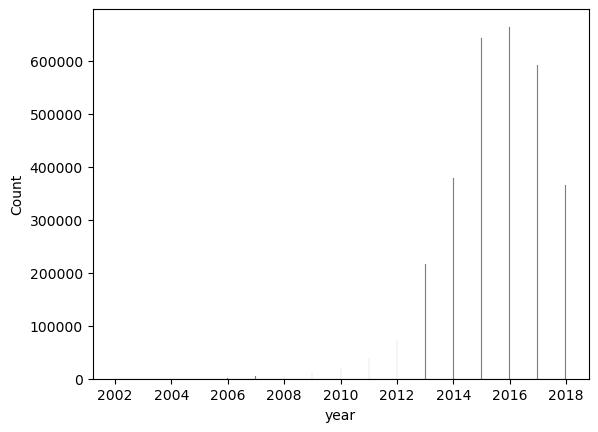

In [89]:
sns.histplot(df_full, x='year')

# Creating Subsets

- Try grouping by asin for reviews alone and checking value counts to see if theres any product with sufficient reviews for analysis.
- Try grouping by brand
- Try grouping by category
- Try ...?

### Subset by asin (product)

In [90]:
overall_by_asin_counts = df_full.groupby('asin')['overall'].value_counts(normalize=False).unstack(1)
overall_by_asin_counts = overall_by_asin_counts.fillna(0).astype(int)
overall_by_asin_counts

overall,1.0,2.0,3.0,4.0,5.0
asin,,,,,
0681727810,0,0,0,0,4
0853347867,0,0,0,0,2
4639725043,4,1,5,6,20
4639725183,0,1,0,3,17
4858582000,0,0,0,1,2
...,...,...,...,...,...
B010R417MI,0,1,0,1,0
B010R4B8OU,0,0,0,0,2
B010R544D6,0,0,0,0,2


In [91]:
overall_by_asin_perc = df_full.groupby('asin')['overall'].value_counts(normalize=True).unstack(1)
overall_by_asin_perc = overall_by_asin_perc.fillna(0).round(3)#.astype(int)
overall_by_asin_perc

overall,1.0,2.0,3.0,4.0,5.0
asin,,,,,
0681727810,0.000,0.000,0.000,0.000,1.000
0853347867,0.000,0.000,0.000,0.000,1.000
4639725043,0.111,0.028,0.139,0.167,0.556
4639725183,0.000,0.048,0.000,0.143,0.810
4858582000,0.000,0.000,0.000,0.333,0.667
...,...,...,...,...,...
B010R417MI,0.000,0.500,0.000,0.500,0.000
B010R4B8OU,0.000,0.000,0.000,0.000,1.000
B010R544D6,0.000,0.000,0.000,0.000,1.000


<!-- ##### Could do by Pr -->

In [92]:
# Get the 100 products with the most 1 star reviews
asin_most_ones = overall_by_asin_counts[1.0].nlargest(1000)
asin_most_ones

asin
B007JINB0W    1070
B00542YXFW     671
B00BUKL666     458
B00K2RY8GI     429
B00C1LXBFC     369
              ... 
B000G7TBUW      24
B000HDKZK0      24
B001HTJ2BQ      24
B001OTEC78      24
B001U2BB1Y      24
Name: 1.0, Length: 1000, dtype: int64

In [93]:
# Get the 100 products with the most 5 star reviews
asin_most_fives = overall_by_asin_counts[5.0].nlargest(1000)
asin_most_fives

asin
B00BUKL666    8001
B008QMX2SG    6245
B00D3M2QP4    6228
B00542YXFW    5708
B00DS842HS    4843
              ... 
B003SO9QZA     242
B004LLGBQG     242
B004VLVOJ0     242
B006045OH4     242
B00DUMDNTU     242
Name: 5.0, Length: 1000, dtype: int64

In [94]:
# Select product ids that appear in both overall review counts
filter_asin_most_shared = asin_most_fives.index.isin(asin_most_ones.index)
filter_asin_most_shared[:5]

array([ True,  True,  True,  True,  True])

In [95]:
# Getting overlapping columns
asin_most_shared = asin_most_fives.index[filter_asin_most_shared]
print(asin_most_shared[:5])
len(asin_most_shared)

Index(['B00BUKL666', 'B008QMX2SG', 'B00D3M2QP4', 'B00542YXFW', 'B00DS842HS'], dtype='object', name='asin')


534

In [96]:
# Saving final selected asin ids
selected_product_asins = asin_most_shared.copy()
len(selected_product_asins)

534

In [97]:
# Get filtered dataframe of only these products
df_shared = df_full.loc[ df_full['asin'].isin(selected_product_asins)]
# Reset Index
df_shared = df_shared.reset_index(drop=True)
df_shared

,asin,reviewerID,reviewText,summary,overall,year
0,B000168QTU,AVSVOKDI0AGR7,even just the smell of this when its brewing has a calming effect\n\nit is sweet and yummy. it has no caffiene naturally but does not make you sleepy,highly reccomend,5.0,2006
1,B000168QTU,A29VK02X6I2HYO,"This tea is the closet to real tea you can get with out extra caffiene of regular tea. I mix 4 bags of this tea with 3 bags of organic black tea, and 3 bags of organic green tea. It makes a more h...",like it,4.0,2006
2,B000168QTU,A3M4QZCQV0GOUY,We all have stressful days and upset stomachs. I reccomend this tea for comforting your tummy.,Mint Magic,5.0,2006
3,B0001LO3FG,AQEQS5LG6W42M,I love Twinings Earl Grey Tea and I was thrilled that Amazon is carrying it at such a great price. Thanks Amazon,Great tea at a great price,5.0,2006
4,B0001LO3FG,A3B154HNGLMSG8,I knew this decaf tea by Amazon.com\n\nI have to recomended because is the only decaf tea that I know have a tea taste.....\n\nIs delicious!!!!!!!!!!! Twinings have the most delicious tea that I t...,Tasty decaf tea!!!!!!!!!!!,5.0,2006
...,...,...,...,...,...,...
589700,B010OITYIQ,A1QZAYTL1DUKRI,"I am no expert on tea and only have it a few times a week, but for those that like a natural 'comes from the earth' kind of taste, you will enjoy this tea.",A Very Natural Taste,5.0,2018
589701,B010OITYIQ,AX9GG664AI8XN,Bought it for my daughter. She liked it.,She liked it.,5.0,2018
589702,B010OITYIQ,A1V2LR7H4XRVNK,"High quality product. They give you a freebie for leaving a review, so it's essentially a BOGO offer.",Good matcha.,5.0,2018
589703,B010OITYIQ,A3JBXHCRORQKGB,"Great taste, quality and price. Ill be ordering again.",Great Value,5.0,2018


In [98]:
# Check how many reviews for most common product
top_25_most_reviews = df_shared['asin'].value_counts().head(25)
top_25_most_reviews

asin
B00BUKL666    10314
B00542YXFW     8631
B008QMX2SG     8008
B00D3M2QP4     7987
B00DS842HS     5834
B002HQCWYM     5829
B00CPZPYLS     5213
B00EDHW7K2     5163
B00C1LXBFC     5096
B00PFDH0IC     5006
B005K4Q1T0     4548
B006CNTR6W     4435
B007JINB0W     4363
B006IOKA9S     4258
B00XA8XWGS     4184
B00WBUX2UM     4084
B00R7PWK7W     4052
B00M2OGS08     4049
B00K2RY8GI     3774
B00KSN9TME     3514
B009OWOKFQ     3408
B00EKLPLU4     3394
B00EDADBSQ     3308
B0027Z5J6G     3250
B0045IO2VQ     3101
Name: count, dtype: int64

#### Filter Metadata by Selected asins

In [99]:
# Set index of df_meta for easy slicing
df_meta = df_meta.set_index('asin')
df_meta

,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,category.1,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
asin,,,,,,,,,,,,,,,,,,,,,,,,,
B00BUKL666,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']]"
B008QMX2SG,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']]"
B00D3M2QP4,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...","

In [100]:
# Filter for only selected products from reviews
df_meta_shared = df_meta.loc[selected_product_asins].reset_index(drop=False)
df_meta_shared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   asin                                             534 non-null    object
 1   category                                         534 non-null    object
 2   description                                      455 non-null    object
 3   title                                            534 non-null    object
 4   brand                                            527 non-null    object
 5   feature                                          134 non-null    object
 6   rank                                             534 non-null    object
 7   main_cat                                         534 non-null    object
 8   price                                            435 non-null    object
 9   imageURL                                   

In [101]:
cols_keep_meta = ['asin','title','brand','category']
df_meta_shared[cols_keep_meta]

,asin,title,brand,category
0,B00BUKL666,"KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"
1,B008QMX2SG,"Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']"
2,B00D3M2QP4,"KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']"
3,B00542YXFW,"Davidson's Tea Bulk, Anise Seed, 16-Ounce Bag",Davidson's Tea,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Matcha']"
4,B00DS842HS,"Viva Naturals Organic Extra Virgin Coconut Oil, 16 Ounce",Viva Naturals,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Cooking Oils, Vinegars & Sprays', 'Oils', 'Coconut']"
...,...,...,...,...
529,B007D7OUE0,TruffleHunter White Truffle Oil (3.38 Oz),TruffleHunter,"['Grocery & Gourmet Food', 'Cooking & Baking', 'Cooking Oils, Vinegars & Sprays', 'Oils', 'Truffle']"
530,B002HQMBYS,"HealthWise Low Acid Swiss Water Decaffeinated Coffee, 100% Colombian Decaf Supremo, 12 Ounce",HealthWise,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Coffee']"
531,B00BKL52YC,"Oreo Mega Stuf Chocolate Sandwich Cookies, 13.2 Ounce",Oreo,"['Grocery & Gourmet Food', 'Snack Foods', 'Cookies', 'Sandwich']"
532,B00MDTUZUG,"Medjool Dates, 1 Pound",Food to Live,"['Grocery & Gourmet Food', 'Produce', 'Dried Fruits & Vegetables', 'Dried Fruits', 'Dried Dates']"


In [102]:
# Save final reviews dataframe with select metadata cols added
df = pd.merge(df_shared, df_meta_shared[cols_keep_meta], on='asin')
df

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B000168QTU,AVSVOKDI0AGR7,even just the smell of this when its brewing has a calming effect\n\nit is sweet and yummy. it has no caffiene naturally but does not make you sleepy,highly reccomend,5.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
1,B000168QTU,A29VK02X6I2HYO,"This tea is the closet to real tea you can get with out extra caffiene of regular tea. I mix 4 bags of this tea with 3 bags of organic black tea, and 3 bags of organic green tea. It makes a more h...",like it,4.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
2,B000168QTU,A3M4QZCQV0GOUY,We all have stressful days and upset stomachs. I reccomend this tea for comforting your tummy.,Mint Magic,5.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
3,B0001LO3FG,AQEQS5LG6W42M,I love Twinings Earl Grey Tea and I was thrilled that Amazon is carrying it at such a great price. Thanks Amazon,Great tea at a great price,5.0,2006,"Twinings of London Pure Camomile Herbal Tea Bags, 20 Count",Twinings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
4,B0001LO3FG,A3B154HNGLMSG8,I knew this decaf tea by Amazon.com\n\nI have to recomended because is the only decaf tea that I know have a tea taste.....\n\nIs delicious!!!!!!!!!!! Twinings have the most delicious tea that I t...,Tasty decaf tea!!!!!!!!!!!,5.0,2006,"Twinings of London Pure Camomile Herbal Tea Bags, 20 Count",Twinings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
...,...,...,...,...,...,...,...,...,...
589700,B010OITYIQ,A1QZAYTL1DUKRI,"I am no expert on tea and only have it a few times a week, but for those that like a natural 'comes from the earth' kind of taste, you will enjoy this tea.",A Very Natural Taste,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589701,B010OITYIQ,AX9GG664AI8XN,Bought it for my daughter. She liked it.,She liked it.,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589702,B010OITYIQ,A1V2LR7H4XRVNK,"High quality product. They give you a freebie for leaving a review, so it's essentially a BOGO offer.",Good matcha.,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589703,B010OITYIQ,A3JBXHCRORQKGB,"Great taste, quality and price. Ill be ordering again.",Great Value,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"


In [103]:
# Getting top 10 most common brands to visualize counts distrubtion
most_common_brand_counts = df['brand'].value_counts().head(10)
most_common_brand_counts

brand
KIND                              37896
Viva Naturals                     17590
Twinings                          14967
Planters                           9831
Davidson's Tea                     9124
Crazy Cups                         8889
Healthworks                        8456
SAN FRANCISCO BAY                  8402
Green Mountain Coffee Roasters     8276
Death Wish Coffee Co.              8102
Name: count, dtype: int64

In [104]:
# df.groupby()

## Saving Most Reviewed Common Products Reviews & Metadata CSV 

In [105]:
keep_meta_cols = ['asin','title','brand','description','category','feature','main_cat','imageURL','imageURLHighRes']
df_meta_shared[keep_meta_cols]

,asin,title,brand,description,category,feature,main_cat,imageURL,imageURLHighRes
0,B00BUKL666,"KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U..."
1,B008QMX2SG,"Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf..."
2,B00D3M2QP4,"KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,"'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']",NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa..."
3,B00542YXFW,"Davidson's Tea Bulk, Anise Seed, 16-Ounce Bag",Davidson's Tea,"'Mild, but round and full licorice flavor and aroma.', 'Anise seeds*. (*denotes organic)', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diag...","['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Matcha']",NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/31-bynr4YrL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/31kM2giWN6L._SS40_.jpg'","'https://images-na.ssl-images-amazon.com/images/I/31-bynr4YrL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/31kM2giWN6L.jpg'"
4,B00DS842HS,"Viva Naturals Organic Extra Virgin Coconut Oil, 16 Ounce",Viva Naturals,"'', 'Viva Naturals Organic Coconut Oil gives you an easy, wonderful way to add flavor to your diet, and boost your skin and hair regime with the power of MCTs, immune boosters, and compounds found...","['Grocery & Gourmet Food', 'Cooking & Baking', 'Cooking Oils, Vinegars & Sprays', 'Oils', 'Coconut']",NaN,Grocery,"'https://images-na.ssl-images-amazon.com/images/I/31Bx9IKlBbL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51zbppbbW9L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/31Bx9IKlBbL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51zbppbbW9L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51n1sSlCVw..."
...,...,...,...,...,...,...,...,...,...
529,B007D7OUE0,TruffleHunter White Truffle Oil (3.38 O

In [106]:
# Get rid of fake outer lists from string columns 
list_cols  =['description','imageURL','imageURLHighRes', 'feature']
# ast.literal_eval errored so switching tactics
# df_meta_shared['description-text'] = df_meta_shared['description'].fillna('').map(lambda x: ast.literal_eval(x))#[0])

for col in list_cols:
    df_meta_shared[col] = df_meta_shared[col].fillna('').map(
    lambda x: x.replace('[','').replace(']',''))
df_meta_shared

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,category.1,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']]"
1,B008QMX2SG,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']]"
2,B00D3M2QP4,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...","['Grocery & Gourmet Food', '

# 📌 BOOKMARK END OF 02/07/24

- Resume with the subset selection after loading the files saved below.

In [107]:
# df_meta_shared.duplicated().sum()

In [108]:
df_meta_shared.duplicated(subset=['asin']).sum()

0

In [109]:
df.duplicated(subset=['asin','reviewerID','reviewText']).sum()

0

#### Creating Clean Subset Folder

In [110]:
fpath_meta_subset = FPATHS['data']['subset']['metadata_csv']
fpath_meta_subset

'data/subset/amazon-metadata-subset-grocery-most-common-products.csv.gz'

In [111]:
# folder_subset = "subset/"
# os.makedirs(folder_subset, exist_ok=True)

In [112]:
# Save metadata
# fpath_meta = folder_subset+'amazon-metadata-subset-grocery-most-common-products.csv.gz'
compression_params = {'method': 'gzip', 'compresslevel': 9}
df_meta_shared.to_csv(fpath_meta, index=False, compression=compression_params)

In [113]:
pd.read_csv(fpath_meta)

,asin,category,description,title,brand,feature,rank,main_cat,price,imageURL,imageURLHighRes,details,category.1,Category_Beverages,"Category_Bottled Beverages, Water & Drink Mixes",Category_Candy & Chocolate,"Category_Canned, Jarred & Packaged Foods",Category_Coffee,"Category_Coffee, Tea & Cocoa",Category_Cooking & Baking,Category_Grocery & Gourmet Food,"Category_Herbs, Spices & Seasonings","Category_Sauces, Gravies & Marinades",Category_Snack Foods,Category_Tea,category_list
0,B00BUKL666,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,18 in Grocery & Gourmet Food (,Grocery,$13.67,"'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41LEtFqaNJL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/411zehDfjQL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51v5Q6bn3U...","{'\\n Product Dimensions: \\n ': '6.8 x 6.1 x 2.3 inches ; 1.05 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and t...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[""['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']""]"
1,B008QMX2SG,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information:<br>Contains peanuts and t...","Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz",KIND,NaN,"2,949 in Grocery & Gourmet Food (",Grocery,$14.79,"'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41c9ml7O8PL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41U1Gw4T0VL.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61JnkFyZTf...","{'\\n Product Dimensions: \\n ': '2 x 4 x 6 inches ; 1 pounds', 'Shipping Weight:': '1.2 pounds (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to APO/FPO...","['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']",0,0,0,0,0,0,0,1,0,0,1,0,"[""['Grocery & Gourmet Food', 'Snack Foods', 'Bars', 'Nut Bars']""]"
2,B00D3M2QP4,"['Grocery & Gourmet Food', 'Breakfast Foods', 'Breakfast & Cereal Bars', 'Cereal']","'These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey.', 'Allergen information: contains peanuts, tree nu...","KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count",KIND,NaN,"4,575 in Grocery & Gourmet Food (",Grocery,$15.53,"'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/image...","'https://images-na.ssl-images-amazon.com/images/I/41jDYNkc2-L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41kb2iw9E8L.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51fuf1Wpaa...","{'\\n Product Dimensions: \\n ': '7 x 6 x 2.5 inches ; 5.99 pounds', 'Shipping Weight:': '15.2 ounces (', 'Domestic Shipping: ': 'Currently, item can be shipped only within the U.S. and to A...","['Grocery &

In [114]:
# Get fpath for reviews subset
fpath_reviews_subset = FPATHS['data']['subset']['reviews-subset_most-commonly-reviewed_csv']
fpath_reviews_subset

'data/subset/amazon-reviews-subset-grocery-most-common-products.csv.gz'

In [115]:
# Save reviews
# fpath_reviews = folder_subset+'amazon-reviews-subset-grocery-most-common-products.csv.gz'
df.to_csv(fpath_reviews_subset, index=False, compression=compression_params)

In [116]:
pd.read_csv(fpath_reviews_subset)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B000168QTU,AVSVOKDI0AGR7,even just the smell of this when its brewing has a calming effect\n\nit is sweet and yummy. it has no caffiene naturally but does not make you sleepy,highly reccomend,5.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
1,B000168QTU,A29VK02X6I2HYO,"This tea is the closet to real tea you can get with out extra caffiene of regular tea. I mix 4 bags of this tea with 3 bags of organic black tea, and 3 bags of organic green tea. It makes a more h...",like it,4.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
2,B000168QTU,A3M4QZCQV0GOUY,We all have stressful days and upset stomachs. I reccomend this tea for comforting your tummy.,Mint Magic,5.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
3,B0001LO3FG,AQEQS5LG6W42M,I love Twinings Earl Grey Tea and I was thrilled that Amazon is carrying it at such a great price. Thanks Amazon,Great tea at a great price,5.0,2006,"Twinings of London Pure Camomile Herbal Tea Bags, 20 Count",Twinings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
4,B0001LO3FG,A3B154HNGLMSG8,I knew this decaf tea by Amazon.com\n\nI have to recomended because is the only decaf tea that I know have a tea taste.....\n\nIs delicious!!!!!!!!!!! Twinings have the most delicious tea that I t...,Tasty decaf tea!!!!!!!!!!!,5.0,2006,"Twinings of London Pure Camomile Herbal Tea Bags, 20 Count",Twinings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
...,...,...,...,...,...,...,...,...,...
589700,B010OITYIQ,A1QZAYTL1DUKRI,"I am no expert on tea and only have it a few times a week, but for those that like a natural 'comes from the earth' kind of taste, you will enjoy this tea.",A Very Natural Taste,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589701,B010OITYIQ,AX9GG664AI8XN,Bought it for my daughter. She liked it.,She liked it.,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589702,B010OITYIQ,A1V2LR7H4XRVNK,"High quality product. They give you a freebie for leaving a review, so it's essentially a BOGO offer.",Good matcha.,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589703,B010OITYIQ,A3JBXHCRORQKGB,"Great taste, quality and price. Ill be ordering again.",Great Value,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"


- Later to do

# Subsetting from Most Common Product Reviews

### Find Overlap of Products with Most Number of 1s and 5s

### Subset by Brand

In [117]:
# Get the distribution of overall ratings for each brand
overall_by_brand_counts = df.groupby('brand')['overall'].value_counts(normalize=False).unstack(1)
overall_by_brand_counts.head(10)

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
4th & Heart,113,55,91,144,1397
5 Gum,29,13,22,47,364
9GreenBox,111,69,86,101,406
ADHealthyway,52,32,41,73,249
Amish Country Popcorn,83,73,128,147,947
Amoretti,95,49,60,70,383
Amy & Brian,47,25,53,62,336
Ancient Organics,26,17,37,60,1335
Angelino's Coffee,37,30,62,87,374


In [118]:
# Finding brands with the most one-star reviews
most_negative_brand_counts = overall_by_brand_counts.sort_values(1.0, ascending=False).head(100)
most_negative_brand_counts

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
KIND,1753,1180,1956,3682,29325
Miracle Noodle,1070,367,453,605,1868
Crazy Cups,975,698,1096,1326,4794
Davidson's Tea,696,541,708,1142,6037
Viva Naturals,632,309,516,1547,14586
...,...,...,...,...,...
Tim Hortons,103,72,136,207,1795
NOW Foods,101,61,92,175,923
Four Sigma Foods,100,80,116,119,497


In [119]:
# Get the distribution of overall ratings for each brand
overall_by_brand_perc = df.groupby('brand')['overall'].value_counts(normalize=True).unstack(1)
overall_by_brand_perc.head(10)

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
4th & Heart,0.062778,0.030556,0.050556,0.080000,0.776111
5 Gum,0.061053,0.027368,0.046316,0.098947,0.766316
9GreenBox,0.143596,0.089263,0.111255,0.130660,0.525226
ADHealthyway,0.116331,0.071588,0.091723,0.163311,0.557047
Amish Country Popcorn,0.060232,0.052975,0.092888,0.106676,0.687228
Amoretti,0.144597,0.074581,0.091324,0.106545,0.582953
Amy & Brian,0.089866,0.047801,0.101338,0.118547,0.642447
Ancient Organics,0.017627,0.011525,0.025085,0.040678,0.905085
Angelino's Coffee,0.062712,0.050847,0.105085,0.147458,0.633898


In [120]:
# Finding brands with the most one-star reviews
most_negative_brand_perc = overall_by_brand_perc.sort_values(1.0, ascending=False).head(20)
most_negative_brand_perc[[1.0,5.0]]

overall,1.0,5.0
brand,,
KaBloom,0.310287,0.483980
Miracle Noodle,0.245244,0.428146
Nutilight,0.228498,0.388960
Julian Bakery,0.227451,0.496078
Epic Provisions,0.201272,0.470792
Primal Kitchen,0.198899,0.576050
Golden State Fruit,0.190965,0.587269
H2wOw,0.186047,0.525939
Java Factory,0.169685,0.503018


In [121]:
# Getting Brands with 
most_negative_brand_review_counts_stars  = most_negative_brand_counts[[1.0,5.0]].sum(axis=1).sort_values(ascending=False)
top_100_most_1_star_5_star_reviews = most_negative_brand_review_counts_stars.head(100)
top_100_most_1_star_5_star_reviews

brand
KIND             31078
Viva Naturals    15218
Twinings         12455
Planters          7765
Healthworks       6998
                 ...  
9GreenBox          517
Nutilight          481
KaBloom            471
H2wOw              398
Julian Bakery      369
Length: 100, dtype: int64

### 🚨NOTE EOD 02/07/24 - review final selection logic below

In [122]:
overlapping_counts = most_negative_brand_counts[most_negative_brand_counts.index.isin(top_100_most_1_star_5_star_reviews.index)]
overlapping_counts

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
KIND,1753,1180,1956,3682,29325
Miracle Noodle,1070,367,453,605,1868
Crazy Cups,975,698,1096,1326,4794
Davidson's Tea,696,541,708,1142,6037
Viva Naturals,632,309,516,1547,14586
...,...,...,...,...,...
Tim Hortons,103,72,136,207,1795
NOW Foods,101,61,92,175,923
Four Sigma Foods,100,80,116,119,497


In [123]:
overlapping_counts.sort_values(1.0, ascending=False).head(20)

overall,1.0,2.0,3.0,4.0,5.0
brand,,,,,
KIND,1753,1180,1956,3682,29325
Miracle Noodle,1070,367,453,605,1868
Crazy Cups,975,698,1096,1326,4794
Davidson's Tea,696,541,708,1142,6037
Viva Naturals,632,309,516,1547,14586
Custom Variety Pack,574,421,705,941,3086
Stur,528,401,519,760,4819
Brooklyn Beans,515,454,632,895,3437
Twinings,496,365,719,1428,11959


<Axes: ylabel='brand'>

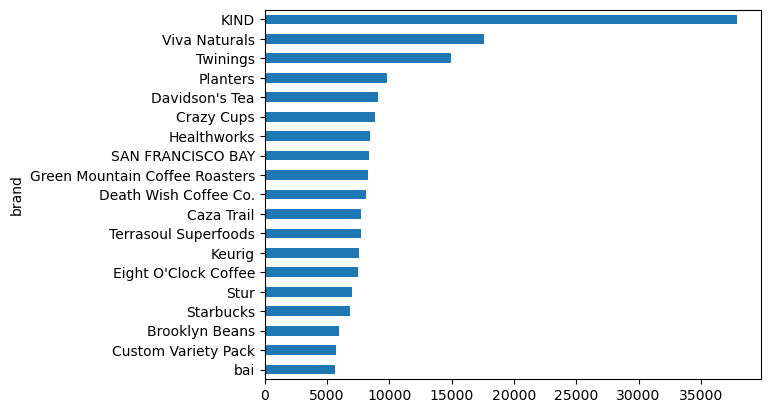

In [124]:
overlapping_counts.sum(axis=1).sort_values().tail(19).plot(kind='barh')

In [125]:
# col = "KIND"
# overlapping_counts.loc[col].plot(kind='barh', title =col)

In [126]:
def get_value_counts_perc(df_final, col='overall',reset_index=False):
    temp = pd.DataFrame({'Counts':df_final[col].value_counts(),
                         'Percent':df_final[col].value_counts(1)*100})
    temp = temp.sort_index()
    temp.index.name = col
    if reset_index:
        temp = temp.reset_index(drop=False)
    return temp

In [127]:
get_value_counts_perc(df)

,Counts,Percent
overall,,
1.0,37856,6.419481
2.0,23884,4.050161
3.0,36486,6.187161
4.0,65410,11.091987
5.0,426069,72.251210


In [128]:
df

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B000168QTU,AVSVOKDI0AGR7,even just the smell of this when its brewing has a calming effect\n\nit is sweet and yummy. it has no caffiene naturally but does not make you sleepy,highly reccomend,5.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
1,B000168QTU,A29VK02X6I2HYO,"This tea is the closet to real tea you can get with out extra caffiene of regular tea. I mix 4 bags of this tea with 3 bags of organic black tea, and 3 bags of organic green tea. It makes a more h...",like it,4.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
2,B000168QTU,A3M4QZCQV0GOUY,We all have stressful days and upset stomachs. I reccomend this tea for comforting your tummy.,Mint Magic,5.0,2006,"Celestial Seasonings Tension Tamer Tea, 20 ct",Celestial Seasonings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea']"
3,B0001LO3FG,AQEQS5LG6W42M,I love Twinings Earl Grey Tea and I was thrilled that Amazon is carrying it at such a great price. Thanks Amazon,Great tea at a great price,5.0,2006,"Twinings of London Pure Camomile Herbal Tea Bags, 20 Count",Twinings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
4,B0001LO3FG,A3B154HNGLMSG8,I knew this decaf tea by Amazon.com\n\nI have to recomended because is the only decaf tea that I know have a tea taste.....\n\nIs delicious!!!!!!!!!!! Twinings have the most delicious tea that I t...,Tasty decaf tea!!!!!!!!!!!,5.0,2006,"Twinings of London Pure Camomile Herbal Tea Bags, 20 Count",Twinings,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
...,...,...,...,...,...,...,...,...,...
589700,B010OITYIQ,A1QZAYTL1DUKRI,"I am no expert on tea and only have it a few times a week, but for those that like a natural 'comes from the earth' kind of taste, you will enjoy this tea.",A Very Natural Taste,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589701,B010OITYIQ,AX9GG664AI8XN,Bought it for my daughter. She liked it.,She liked it.,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589702,B010OITYIQ,A1V2LR7H4XRVNK,"High quality product. They give you a freebie for leaving a review, so it's essentially a BOGO offer.",Good matcha.,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"
589703,B010OITYIQ,A3JBXHCRORQKGB,"Great taste, quality and price. Ill be ordering again.",Great Value,5.0,2018,"TEAki Hut Organic Matcha Green Tea Powder 4 Ounce (100 Servings) Culinary Grade | Excellent Weight Loss Benefits | More Antioxidants than Green Tea Bags | Best for Making Matcha Tea, Smoothies, La...",TEAki Hut,"['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa', 'Tea', 'Green']"


For KIND there are 37896 total reviews.


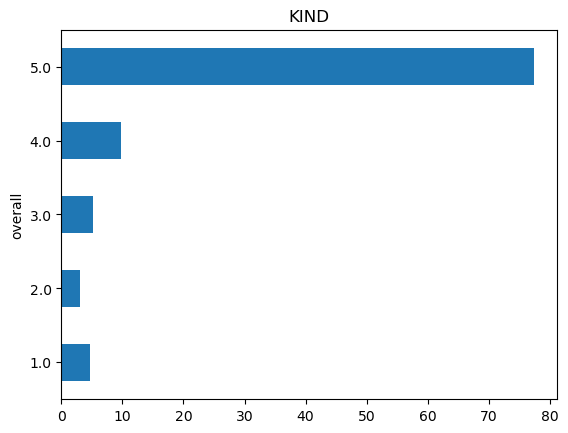



For Miracle Noodle there are 4363 total reviews.


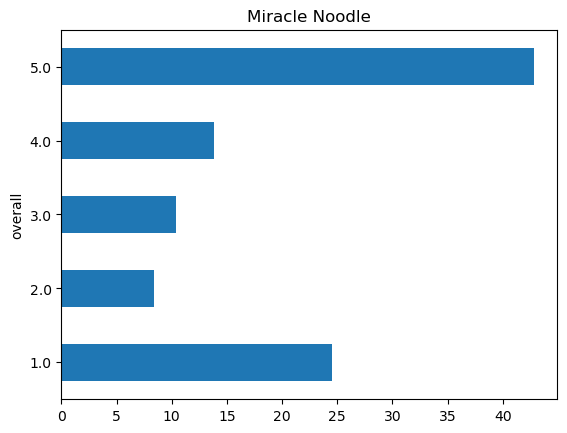



For Twinings there are 14967 total reviews.


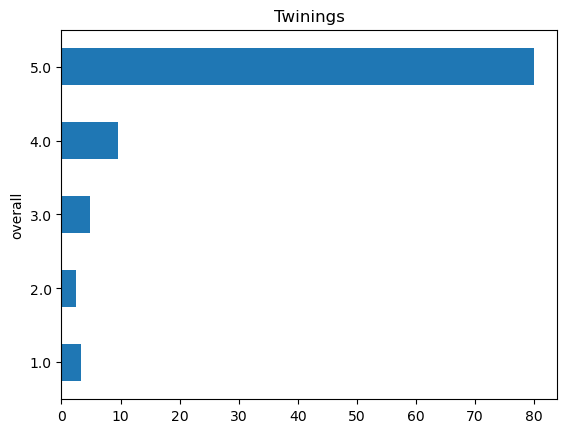

In [129]:
### Debating options (look at cell above and below)
options = ['KIND',#but very imbalanced
           'Miracle Noodle', # 
           'Twinings'
          ]

# col = "KIND"
for col in options:
    temp_df = df.loc[ df['brand']==col].reset_index(drop=True)
    # overlapping_counts.loc[col].plot(kind='barh', title =col) # Got confused as to this vs temp_df below
    # plt.show()
    # temp_df = temp_df.rename({'index':'overall'})
    
    col_counts = get_value_counts_perc(temp_df, col='overall')
    col_counts['brand'] = col
    print(f"For {col} there are {col_counts['Counts'].sum()} total reviews.")

    plt.figure()
    # col_counts['Percent'].plot(kind='barh')
    col_counts['Percent'].plot(kind='barh', title =col)
    plt.show()
    print('='*80,'\n\n')


## BOOKMARK: Decide final brand(s)

In [130]:
# raise Exception('stop here for now')

In [131]:
SELECTED_BRAND  = "Miracle Noodle"
df_final = df.loc[ df['brand']==SELECTED_BRAND].reset_index(drop=True)
df_final

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B007JINB0W,A2G943N32RET14,"I have lost over 105 pounds and low calorie foods are important to me, the spinach noodles are the best tasting miracle noodles of the bunch. Just like any other Shirataki noodles you have to rin...",best one i have tried,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
1,B007JINB0W,A3EHCTP6LQOX7E,"They were O.K. I would ""Not"" buy them again though. The taste was strange, because I could not get past the smell of them when they are first opened up. And the smell stayed in my nose for a lo...",miracle?,3.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
2,B007JINB0W,A2FYEJJ44RTBGV,"Take time to prepare properly (rinse, blanch,dry fry) and you wil find that they taste like whatever else you're eating. I also suggest snipping them into small lengths as you drop them in the boi...",Best diet food ever,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
3,B007JINB0W,A1SAC729TVBB8M,"I use this as a substitute for pasta. Have it with tomatoes, peppers, garlic and parmesan cheese. It'll never replace the real thing for me but, can't beat the calories.",Review,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4,B007JINB0W,AYDHHE3PWRBGI,The noodles are fine - my rating has nothing to do with the person or place we bought them from. We have had Shiratake noodles before - these are not quite as yummy as the others we have purchased.,Shirataki noodles,3.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A1LYEKEFISH0M7,I am a big pasta fan so trying to cut back on carbs for health reasons wasn't easy. These are a great substitute!!! It tastes just like rice noodles or very mild overall. Its not a spaghetti subst...,Great if you are looking for a substitute for pasta/rice,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4359,B007JINB0W,A1SKVZRHLR5FDM,These are really good and no calories. Works great on my weight watchers plan.,Yummy,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4360,B007JINB0W,A3PQJ32GSDJ42Q,I can usually handle any taste or texture. I read the reviews but I know I can generally us whatever and get by. Even used an Alfredo sauce and found it so horrible I just couldn't force myself to...,Worse food product I have EVER put in my mouth,1.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4361,B007JINB0W,A2NCWAZKP84T7Y,I am thrilled with these noodles! Im a t1 diabetic and as promised on the package there are no carbohydrates. My blood sugar was 118 before I ate them and 120 an hour after.,Delicious and guilt free,5.0,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"


In [132]:
# pd.DataFrame({'# Null':df_final['overall'].value_counts(),'% Null':df_final['overall'].value_counts(1)})

In [133]:
df_final['overall'].value_counts()

overall
5.0    1868
1.0    1070
4.0     605
3.0     453
2.0     367
Name: count, dtype: int64

In [134]:
df_final['overall'].value_counts(1)

overall
5.0    0.428146
1.0    0.245244
4.0    0.138666
3.0    0.103828
2.0    0.084116
Name: proportion, dtype: float64

In [135]:
# SELECTED_BRAND  = "Tropicana"#$"KIND"
# new_column_order = [
#     #'text'.
#     'reviewText',
#     'summary',    
#     'overall',
#     'brand',
#     'title']

#, new_column_order]
# Shuffling Rows & Reset Index
df_final = df_final.sample(frac=1, replace=False)
df_final = df_final.reset_index(drop=True)
df_final

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B007JINB0W,A2RQQKUDKUPUO9,"I was reading reviews on this product and was so excited. But I gagged when I tried them. Ill take regular pasta any day over this weird stuff! So gross, the texture is very very hard to get over.",I was reading reviews on this product and was so ...,1.0,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
1,B007JINB0W,A1DW1LKZEWPKNC,Working on the low carb lifestyle and would not make it without this product. Definitely worth the price and will definitely purchase again.,Working on the low carb lifestyle and would not make ...,4.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
2,B007JINB0W,A28C1309S1WFLR,"I followed the directions other people posted ,rinse longer than stated,and cook at least 5-6 minutes,i add these to my pasta sauce early afternoon so that they have a chance to absorb as much fla...",Not Bad,4.0,2013,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
3,B007JINB0W,A2QIJY7RFGZC23,I have tried soooo many pasta substitutes. The promises were always hollow and the wanna be pastas were always gross in taste or texture or both. If you follow the instructions and cook these in ...,MUST have for a pasta fanatic on a low/lower carb diet,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4,B007JINB0W,A3CU5S5P90JUIX,"Follow the instructions, rinse and boil. They have no bad flavor and provide the rice/noodle experience. If they weren't so pricey, I'd start buying in bulk immediately. All products are the sa...",They have no bad flavor and provide the rice/noodle experience,5.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,AL3Q8HIANLRKJ,"These are my favorite flavor, my friends agree and love it.",Best Noods,5.0,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4359,B007JINB0W,A1VCFDBW9W5O99,Opened the box to find one of the packages was open and had leaked. Will not be buying again.,One Star,1.0,2015,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4360,B007JINB0W,A361G13N6TQPKS,Smelled so bad I threw it out please don't send me anymore communications please,One Star,1.0,2017,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4361,B007JINB0W,A1U51MX13ZIBT0,this stuff is awful feels like rubber in your mouth,this stuff is awful feels like rubber in your,1.0,2017,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"


In [136]:
df_final['overall'].value_counts()

overall
5.0    1868
1.0    1070
4.0     605
3.0     453
2.0     367
Name: count, dtype: int64

### Save Final Selected Reviews

In [137]:
fname = FPATHS['data']['subset']['reviews-subset_selected-brand_csv']
fname

'data/subset/amazon-reviews-subset-brand-Miracle Noodle.csv'

In [138]:
# # folder_subset = "subset/"
# # os.makedirs(folder_subset, exist_ok=True)

# fname = f"{folder_subset}amazon-reviews-subset-brand-{SELECTED_BRAND}.csv.gz"
# fname

In [139]:
if fname.endswith('gz'):
    compression = compression_params
else:
    compression = None
df_final.to_csv(fname, compression=compression,
                index=False)
pd.read_csv(fname)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category
0,B007JINB0W,A2RQQKUDKUPUO9,"I was reading reviews on this product and was so excited. But I gagged when I tried them. Ill take regular pasta any day over this weird stuff! So gross, the texture is very very hard to get over.",I was reading reviews on this product and was so ...,1.0,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
1,B007JINB0W,A1DW1LKZEWPKNC,Working on the low carb lifestyle and would not make it without this product. Definitely worth the price and will definitely purchase again.,Working on the low carb lifestyle and would not make ...,4.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
2,B007JINB0W,A28C1309S1WFLR,"I followed the directions other people posted ,rinse longer than stated,and cook at least 5-6 minutes,i add these to my pasta sauce early afternoon so that they have a chance to absorb as much fla...",Not Bad,4.0,2013,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
3,B007JINB0W,A2QIJY7RFGZC23,I have tried soooo many pasta substitutes. The promises were always hollow and the wanna be pastas were always gross in taste or texture or both. If you follow the instructions and cook these in ...,MUST have for a pasta fanatic on a low/lower carb diet,5.0,2012,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4,B007JINB0W,A3CU5S5P90JUIX,"Follow the instructions, rinse and boil. They have no bad flavor and provide the rice/noodle experience. If they weren't so pricey, I'd start buying in bulk immediately. All products are the sa...",They have no bad flavor and provide the rice/noodle experience,5.0,2016,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,AL3Q8HIANLRKJ,"These are my favorite flavor, my friends agree and love it.",Best Noods,5.0,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4359,B007JINB0W,A1VCFDBW9W5O99,Opened the box to find one of the packages was open and had leaked. Will not be buying again.,One Star,1.0,2015,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4360,B007JINB0W,A361G13N6TQPKS,Smelled so bad I threw it out please don't send me anymore communications please,One Star,1.0,2017,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"
4361,B007JINB0W,A1U51MX13ZIBT0,this stuff is awful feels like rubber in your mouth,this stuff is awful feels like rubber in your,1.0,2017,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']"


In [140]:
import boto3

s3 = boto3.client('s3')
s3.upload_file(fname, FPATHS['data']['s3']['bucket'], os.path.basename(fname))

In [141]:
# List all files in the bucket
response = s3.list_objects_v2(Bucket=FPATHS['data']['s3']['bucket'])
for obj in response['Contents']:
    print(obj['Key'])

Grocery_and_Gourmet_Food_5.json.gz
amazon-metadata-groceries-combined.csv.gz
amazon-reviews-subset-brand-Miracle Noodle.csv
meta_Grocery_and_Gourmet_Food.json.gz
reviews-df-final.csv.gz
